In [1]:
rm(list=ls())

# Librerías ====
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse, showtext, srvyr,httr,utils,foreign)
remotes::install_github("cpyp-ipdp/funcionespgd", force = TRUE)
library(funcionespgd)
font_add_google("Poppins", "pop")
showtext_auto()

Cargando paquete requerido: pacman

Using GitHub PAT from the git credential store.




rlang  (1.1.4 -> 1.1.6) [CRAN]
glue   (1.7.0 -> 1.8.0) [CRAN]
cli    (3.6.3 -> 3.6.5) [CRAN]
tibble (3.2.1 -> 3.3.0) [CRAN]


Installing 4 packages: rlang, glue, cli, tibble

Warning message:
"package 'tibble' is in use and will not be installed"
Installing packages into 'C:/Users/claud/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'rlang' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'rlang'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\rlang\libs\x64\rlang.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\rlang\libs\x64\rlang.dll: Permission denied"
Warning message:
"restored 'rlang'"


package 'glue' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'glue'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\glue\libs\x64\glue.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\glue\libs\x64\glue.dll: Permission denied"
Warning message:
"restored 'glue'"


package 'cli' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'cli'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\cli\libs\x64\cli.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\cli\libs\x64\cli.dll: Permission denied"
Warning message:
"restored 'cli'"



The downloaded binary packages are in
	C:\Users\claud\AppData\Local\Temp\RtmpMl7sC9\downloaded_packages
── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file 'C:\Users\claud\AppData\Local\Temp\RtmpMl7sC9\remotes924c1a674095\cpyp-ipdp-funcionespgd-6fd64b9/DESCRIPTION' ... OK
* preparing 'funcionespgd':
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted 'LazyData' from DESCRIPTION
* building 'funcionespgd_0.1.0.tar.gz'



Installing package into 'C:/Users/claud/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



In [2]:
dir.create("nacimientos", showWarnings = FALSE)
url_1_default <- "https://www.inegi.org.mx/contenidos/programas/natalidad/microdatos/"
url_1_2016    <- "https://www.inegi.org.mx/contenidos/programas/natalidad/Microdatos/"  # Nota: 'M' mayúscula
url_2 <- "natalidad_base_datos_"
years <- 1985:2023

root_dir <- "nacimientos"


In [3]:
options(timeout=600)
for (yr in years) {
  fin <- if (yr %in% 2024) "_csv.zip" else "_dbf.zip"
  base_url <- if (yr == 2016) url_1_2016 else url_1_default
  url <- paste0(base_url, yr, "/", url_2, yr, fin)

  dest_zip <- file.path(root_dir, paste0(yr, fin))
  message("Descargando: ", url)

  dl_ok <- tryCatch({
    utils::download.file(url, destfile = dest_zip, mode = "wb", quiet = TRUE)
    TRUE
  }, error = function(e) {
    message("  ❌ Error en la descarga (", yr, "): ", conditionMessage(e))
    FALSE
  })
  if (!dl_ok || !file.exists(dest_zip)) next

  # Registrar estado previo para identificar qué archivos aparecen tras unzip
  before_files <- list.files(root_dir, recursive = TRUE, full.names = TRUE)

  uz_ok <- tryCatch({
    utils::unzip(dest_zip, exdir = root_dir)
    TRUE
  }, error = function(e) {
    message("  ❌ Error en la descompresión (", yr, "): ", conditionMessage(e))
    FALSE
  })
  if (!uz_ok) {
    message("  ⚠️  Conservando ZIP por fallo en descompresión: ", dest_zip)
    next
  }

  # Identificar nuevos archivos creados por este unzip
  after_files <- list.files(root_dir, recursive = TRUE, full.names = TRUE)
  new_paths <- setdiff(after_files, before_files)

  # Filtrar solo archivos (no directorios) y que no sean .zip
  new_files <- new_paths[file.exists(new_paths)]
  new_files <- new_files[!dir.exists(new_files)]
  new_files <- new_files[!grepl("\\.zip$", new_files, ignore.case = TRUE)]

  # Mover al root y resolver colisiones
  for (src in new_files) {
    tgt_name <- basename(src)
    tgt <- file.path(root_dir, tgt_name)

    if (normalizePath(dirname(src)) == normalizePath(root_dir)) {
      # Ya está en root, no mover
      next
    }

    if (file.exists(tgt)) {
      # Si hay colisión, insertamos _<año> antes de la extensión
      base <- tools::file_path_sans_ext(tgt_name)
      ext  <- tools::file_ext(tgt_name)
      if (nzchar(ext)) {
        tgt <- file.path(root_dir, paste0(base, "_", yr, ".", ext))
      } else {
        tgt <- file.path(root_dir, paste0(base, "_", yr))
      }
    }

    # Crear carpeta destino si no existe (es root, pero por seguridad)
    dir.create(dirname(tgt), recursive = TRUE, showWarnings = FALSE)

    ok_move <- tryCatch({
      file.rename(src, tgt)
    }, warning = function(w) FALSE, error = function(e) FALSE)

    if (!ok_move) {
      # Si file.rename falla (p.ej. entre discos), usar copia + borrado
      ok_copy <- tryCatch({
        file.copy(src, tgt, overwrite = FALSE)
      }, warning = function(w) FALSE, error = function(e) FALSE)
      if (isTRUE(ok_copy)) unlink(src)
    }
  }

  # Limpiar directorios vacíos creados durante el unzip
  # (solo dentro de nacimientos/)
  dirs_created <- unique(dirname(setdiff(after_files, before_files)))
  dirs_created <- dirs_created[dirs_created != root_dir]
  # Orden inverso para borrar de adentro hacia afuera
  dirs_created <- dirs_created[order(nchar(dirs_created), decreasing = TRUE)]
  for (d in dirs_created) {
    if (dir.exists(d)) {
      # Si está vacío, lo borra; si no, lo deja
      try(unlink(d, recursive = FALSE, force = TRUE), silent = TRUE)
      # Intento extra: si sigue habiendo subcarpetas vacías, intentar recursivo pero seguro
      if (dir.exists(d) && length(list.files(d, recursive = TRUE)) == 0) {
        try(unlink(d, recursive = TRUE, force = TRUE), silent = TRUE)
      }
    }
  }

  # Borrar ZIP
  rm_ok <- tryCatch({
    file.remove(dest_zip)
  }, error = function(e) {
    message("  ⚠️  Error al eliminar el ZIP (", yr, "): ", conditionMessage(e))
    FALSE
  })
  if (isTRUE(rm_ok)) {
    message("  ✅ Año ", yr, ": extraído en ", root_dir, " y ZIP eliminado.")
  } else {
    message("  ✅ Año ", yr, ": extraído en ", root_dir, ". (ZIP conservado)")
  }
}

Descargando: https://www.inegi.org.mx/contenidos/programas/natalidad/microdatos/1985/natalidad_base_datos_1985_dbf.zip

  ✅ Año 1985: extraído en nacimientos y ZIP eliminado.

Descargando: https://www.inegi.org.mx/contenidos/programas/natalidad/microdatos/1986/natalidad_base_datos_1986_dbf.zip

  ✅ Año 1986: extraído en nacimientos y ZIP eliminado.

Descargando: https://www.inegi.org.mx/contenidos/programas/natalidad/microdatos/1987/natalidad_base_datos_1987_dbf.zip

  ✅ Año 1987: extraído en nacimientos y ZIP eliminado.

Descargando: https://www.inegi.org.mx/contenidos/programas/natalidad/microdatos/1988/natalidad_base_datos_1988_dbf.zip

  ✅ Año 1988: extraído en nacimientos y ZIP eliminado.

Descargando: https://www.inegi.org.mx/contenidos/programas/natalidad/microdatos/1989/natalidad_base_datos_1989_dbf.zip

  ✅ Año 1989: extraído en nacimientos y ZIP eliminado.

Descargando: https://www.inegi.org.mx/contenidos/programas/natalidad/microdatos/1990/natalidad_base_datos_1990_dbf.zip



In [4]:
##Identificar los archivos que contengan Nacim
lista_archivos <- list.files(path = "nacimientos", full.names = TRUE)

archivos_nac <- lista_archivos %>%
  str_subset("/[Nn][Aa][Cc][Ii][Mm]")   
archivos_nac

[1] "nacimientos/NACIM00.dbf" "nacimientos/NACIM01.dbf"
 [3] "nacimientos/NACIM02.dbf" "nacimientos/NACIM03.dbf"
 [5] "nacimientos/NACIM04.dbf" "nacimientos/NACIM05.dbf"
 [7] "nacimientos/NACIM06.dbf" "nacimientos/NACIM07.dbf"
 [9] "nacimientos/NACIM08.dbf" "nacimientos/NACIM09.dbf"
[11] "nacimientos/NACIM10.dbf" "nacimientos/NACIM11.dbf"
[13] "nacimientos/NACIM12.dbf" "nacimientos/NACIM13.dbf"
[15] "nacimientos/NACIM14.dbf" "nacimientos/NACIM15.dbf"
[17] "nacimientos/NACIM16.DBF" "nacimientos/NACIM17.DBF"
[19] "nacimientos/NACIM18.DBF" "nacimientos/NACIM19.DBF"
[21] "nacimientos/NACIM20.DBF" "nacimientos/nacim21.dbf"
[23] "nacimientos/nacim22.dbf" "nacimientos/nacim23.dbf"
[25] "nacimientos/NACIM85.dbf" "nacimientos/NACIM86.dbf"
[27] "nacimientos/NACIM87.dbf" "nacimientos/NACIM88.dbf"
[29] "nacimientos/NACIM89.dbf" "nacimientos/NACIM90.dbf"
[31] "nacimientos/NACIM91.dbf" "nacimientos/NACIM92.dbf"
[33] "nacimientos/NACIM93.dbf" "nacimientos/NACIM94.dbf"
[35] "nacimientos/NACIM95.dbf" "nacimientos/NACIM96.dbf"
[37] "nacimientos/NACIM97.dbf" "nacimientos/NACIM98.dbf"
[39] "nacimientos/NACIM99.dbf"

In [5]:
embarazo_adolescente <- function(path, entidad = 9) {
  # 1) extraer año de los dos últimos dígitos del nombre
  suf2 <- str_match(basename(path), "(?i)nacim(\\d{2})")[,2] |> as.integer()
  year <- ifelse(suf2 >= 85, 1900 + suf2, 2000 + suf2)

  # 2) leer base y limpiar
  df <- read.dbf(path, as.is = TRUE) |>
    janitor::clean_names() |>
     mutate(ent_resid = as.integer(ent_resid))

  # 3) filtrar por entidad (si se pide)
  if (!is.null(entidad)) {
    df <- filter(df, ent_resid == entidad)
  }

  # 4) calcular métricas
  total_nac      <- nrow(df)
  nac_menores19  <- sum(df$edad_madn >= 15 & df$edad_madn <= 19, na.rm = TRUE)
  pct  <- 100 * nac_menores19 / total_nac

  tibble(
    year,
    total_nac,
    nac_menores19,
    pct
  )
}

In [6]:
nac_embarazo_adolescente <- map_dfr(archivos_nac, embarazo_adolescente, entidad = 9)%>%
  arrange(year)

nac_embarazo_adolescente

year,total_nac,nac_menores19,pct
<dbl>,<int>,<int>,<dbl>
1985,262424,34523,13.155428
1986,258739,34851,13.469558
1987,267370,41356,15.467704
1988,255531,39082,15.294426
1989,247752,37865,15.283429
1990,233828,35411,15.144037
1991,222105,34586,15.571914
1992,224702,31566,14.047939
1993,220978,31088,14.068369


In [7]:
tcma<-((nac_embarazo_adolescente$pct[nac_embarazo_adolescente$year==2023]/nac_embarazo_adolescente$pct[nac_embarazo_adolescente$year==2018])^(1/(2022-2018))-1)

tcma

[1] -0.08496132

In [8]:
extendido<-data.frame(year=2024:2045)
extendido$pct<-nac_embarazo_adolescente$pct[nac_embarazo_adolescente$year==2023]*cumprod(rep(1+tcma,length(2024:2045)))
extendido%>%
mutate(pct=round(pct,2))

year,pct
<int>,<dbl>
2024,7.99
2025,7.31
2026,6.69
2027,6.12
2028,5.60
2029,5.12
2030,4.69
2031,4.29
2032,3.93


In [9]:
 serie_completa <- dplyr::bind_rows(
    nac_embarazo_adolescente %>%
      dplyr::mutate(year = as.numeric(year)) %>%
      intervals(margen = 0, año_base = 2023,var = "pct"),

    extendido %>%
      dplyr::mutate(year = as.numeric(year)) %>%
      intervals(margen = 0.05, año_base = 2023,var="pct"))
serie_completa

year,estimado,superior,inferior
<dbl>,<dbl>,<dbl>,<dbl>
1985,13.15543,13.15543,13.15543
1986,13.46956,13.46956,13.46956
1987,15.46770,15.46770,15.46770
1988,15.29443,15.29443,15.29443
1989,15.28343,15.28343,15.28343
1990,15.14404,15.14404,15.14404
1991,15.57191,15.57191,15.57191
1992,14.04794,14.04794,14.04794
1993,14.06837,14.06837,14.06837


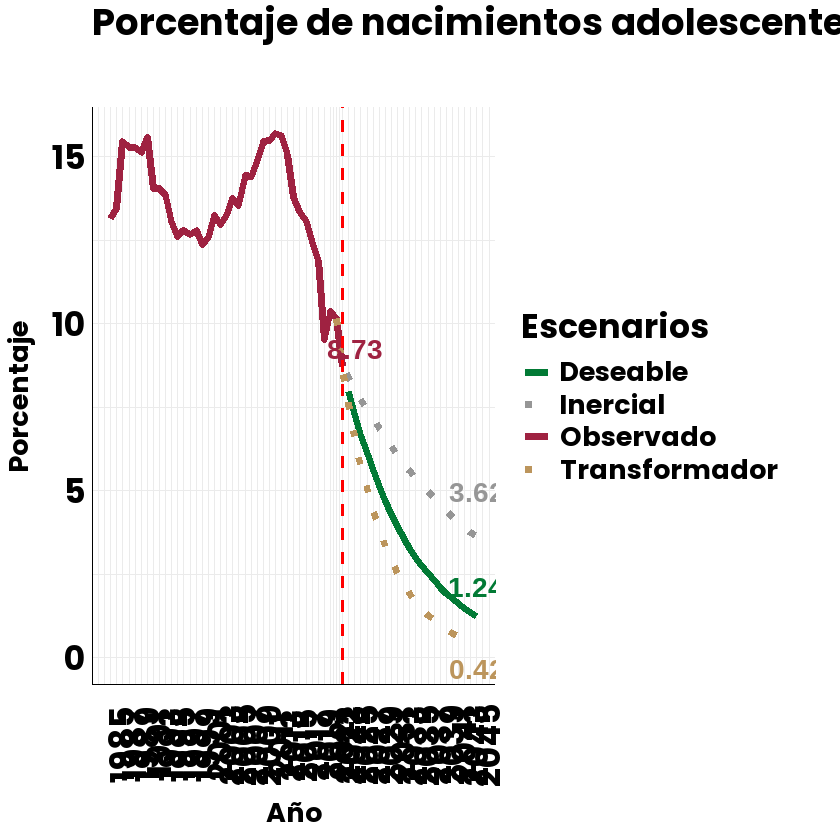

In [12]:
grafica_bonita(
  data = serie_completa,
  x = "year",
  y = "estimado",
  titulo = "Porcentaje de nacimientos adolescentes en la Ciudad de México
",
    ano_base = 2023,
  mostrar_etiqueta_ano_base = TRUE,
  linea_vertical = 2023,
  anios_etiquetas = c(2045),
    desplazamiento_ano_base=c(2, 0.5),
  mostrar_intervalo = "ambos",
  nombre_observado = "Observado",
  nombre_estimado_futuro = "Deseable",
  nombre_intervalo_superior = "Inercial",
  nombre_intervalo_inferior = "Transformador",
  mostrar_leyenda = TRUE,
  fuente = "pop",
  etiqueta_x = "Año",
  etiqueta_y = "Porcentaje",
  titulo_leyenda = "Escenarios",
  limite_inferior_y = 0
)

ggsave("H:/Mi unidad/pgd/graficas/embarazo_adol_estimada.png",
 width = 10, height = 6, dpi = 200, bg = "white")